# Deep Learning &mdash; Assignment 9

Assignment for week 9 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will

1. Implement and train a generative adversarial network.
2. Experiment with reverse gradient training.
3. Implement a CycleGAN.
4. Experiment with CycleGAN optimization.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.
* `PIL`, the python image library

All libraries can be installed with `pip install`.

In [1]:
# render plots as png, not as svg
# (svg is very slow with large scatterplots)
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import csv
import glob
import re
from collections import defaultdict
import numpy as np
import scipy
import sklearn.datasets
import matplotlib.pyplot as plt
import PIL
import torch
import torch.autograd
import torchvision
import torchvision.transforms
from d2l import torch as d2l

from IPython import display

device = d2l.try_gpu()
# device = 'cpu'

# Fix the seed to make the solutions more reproducible
torch.manual_seed(12345);

## 9.1 Moon dataset

The noisy moon dataset is a synthetic dataset with the following distribution:

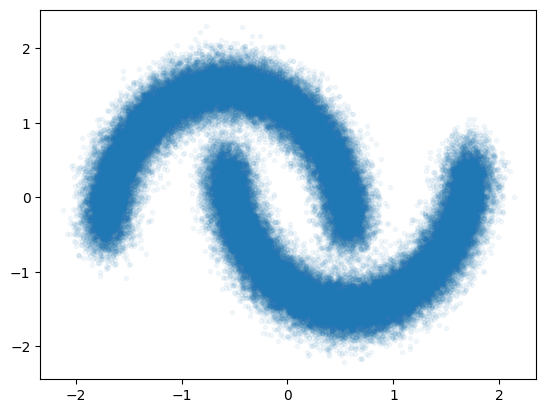

In [2]:
n_samples = 100000
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons[0][:, 0] -= np.mean(noisy_moons[0][:, 0])
noisy_moons[0][:, 0] /= np.std(noisy_moons[0][:, 0])
noisy_moons[0][:, 1] -= np.mean(noisy_moons[0][:, 1])
noisy_moons[0][:, 1] /= np.std(noisy_moons[0][:, 1])
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], '.', alpha=0.05);

**(a) Run the following code to convert the data to a PyTorch dataset:**

In [3]:
moon_dataset = torch.utils.data.TensorDataset(torch.tensor(noisy_moons[0], dtype=torch.float32),
                                              torch.tensor(noisy_moons[1], dtype=torch.float32))

## 9.2 Generator

We define a generator that generates samples from a learned distribution, based on a random noise input.

The generator accepts 1D input vector with 100 elements and has to output a 1D vector with 2 elements.

In [4]:
class MoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)

**(a) Generate some samples from this generator before training and plot the resulting distribution.**

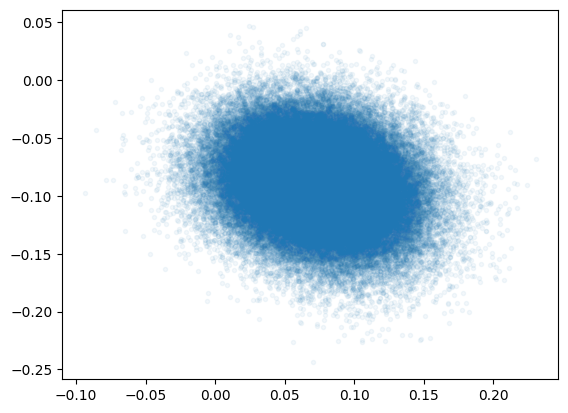

In [5]:
gen = MoonGenerator()
x = torch.rand((n_samples, 100)) * 2 - 1
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.05);

## 9.3 Untrainable dummy generator network

For our experiments, we also define an untrainable dummy generator network that produces samples from a uniform distribution. We'll use this later to investigate what our discriminator learns.

In [6]:
class UniformMoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dummy_param = torch.nn.Parameter(torch.tensor([0.]))

    def forward(self, x):
        return torch.rand((x.shape[0], self.output_size),
                          device=x.device, dtype=x.dtype) * 4 - 2

**(a) Run the code to generate some samples from this generator and plot the resulting distribution.**

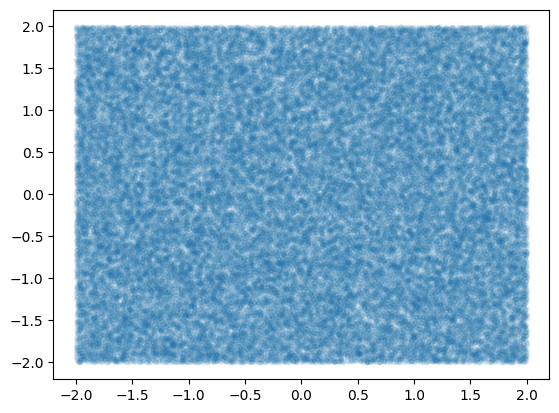

In [7]:
gen = UniformMoonGenerator()
x = torch.randn((n_samples, 100))
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.05);

## 9.4 Discriminator (1 point)

To train the generator, we need a discriminator that takes the samples from the generator and samples from the real distribution. For real samples, the discriminator should predict 1, for fake samples it should predict 0.

For stability, we will exclude the final sigmoid activation from the discriminator and use the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) function during training.

**(a) Inspect the code for the discriminator below:**

In [8]:
class MoonDiscriminator(torch.nn.Module):
    def __init__(self, inputs=2, hiddens=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, 1)
        )
        # Note: Although this is a binary classifier, we do not yet apply
        #       a sigmoid activation here. Instead, we'll use the
        #       BCEWithLogitsLoss later to compute sigmoid + BCE loss in
        #       a numerically stable way.

    def forward(self, x):
        return self.net(x)

We can plot the value of the discriminator in our sample space to see what it is doing.

**(b) Run the code to plot the output of an untrained discriminator:**

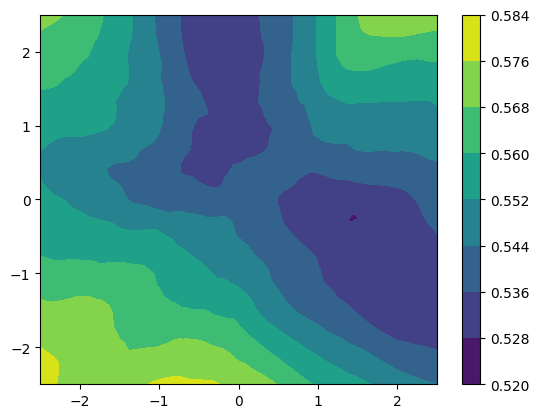

In [9]:
def plot_discriminator(discriminator, xmin=-2.5, xmax=2.5, steps=500, device=device):
    x0, x1 = torch.meshgrid(torch.linspace(xmin, xmax, steps=steps),
                            torch.linspace(xmin, xmax, steps=steps), indexing='ij')
    x = torch.stack([x0.flatten().to(device), x1.flatten().to(device)], axis=1).to(device)
    y = discriminator(x)
    y = torch.sigmoid(y).detach().cpu().numpy()
    y = y.reshape(x0.shape)
    plt.contourf(x0, x1, y)
    plt.colorbar()

disc = MoonDiscriminator().to(device)
plot_discriminator(disc)

**(c) How should we expect this plot to look after training the discriminator for the moon dataset?<span style="float:right"> (1 point)</span>**

We expect this plot to look similar to the first plot of this assignment; namely that it has a high probability of classifying as real if it is in the shape of the original dataset, and classifying it as fake/generated if it is outside the "two bananas."

## 9.5 Adversarial training loop (1 point)

Now we have a generator and a discriminator, we can attempt to train the model. We will define a training function that implements the adversarial training procedure:

For each minibatch of real samples:
1. Generate a batch of fake samples;
2. Compute the discriminator loss on the real and fake samples;
3. Optimize the discriminator;
4. Generate another batch of fake samples;
5. Compute the generator loss on the fake samples;
6. Update the generator.

To monitor training, we'll print the discriminator and generator loss. We'll also monitor the accuracy of the discriminator (the percentage of correctly labeled real and fake samples) and the 'accuracy' of the generator (the percentage of fake samples incorrectly labeled as real by the discriminator).

**(a) Complete the training loop below:<span style="float:right"> (1 point)</span>**

In [10]:
def train_adversarial(generator, discriminator, data_loader, epochs=10,
                      lr_gen=0.001, lr_disc=0.001, device=device):
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen)
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_disc)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        epoch_disc_acc = 0
        epoch_gen_acc = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            ## 1. Discriminator
            # generate noise for the generator
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            # generate fake samples
            x_fake = generator(rand_for_gen)

            # run discriminator on real and fake samples
            d_real = discriminator(x_real)
            d_fake = discriminator(x_fake)

            # compute discriminator loss
            # - for real samples, the discriminator should predict 1
            # - for fake samples, the discriminator should predict 0
            disc_loss = (bce_logits_loss(d_real, torch.ones_like(d_real)) +
                         bce_logits_loss(d_fake, torch.zeros_like(d_fake)))
            disc_acc = (torch.mean((d_real > 0).to(torch.float)) +
                        torch.mean((d_fake < 0).to(torch.float))) / 2

            # update discriminator
            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()


            ## 2. Generator
            # generate another batch of fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # compute generator loss
            d_fake = discriminator(x_fake)
            # TODO: compute the generator loss using d_fake and bce_logits_loss
            #  and the appropriate target value (see the implementation for
            #  the discriminator loss)
            gen_loss = (bce_logits_loss(d_fake, torch.ones_like(d_fake)))
            # for the generator, we compute how many generated samples were given
            # the label 'real' by the discriminator
            gen_acc = torch.mean((d_fake > 0).to(torch.float))

            # update generator
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            ## 3. Statistics
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            epoch_disc_acc += disc_acc.item()
            epoch_gen_acc += gen_acc.item()
            mb_count += 1

        print('Epoch %d: disc_loss=%f gen_loss=%f  disc_acc=%f gen_acc=%f' %
              (epoch, epoch_disc_loss / mb_count, epoch_gen_loss / mb_count,
               epoch_disc_acc / mb_count, epoch_gen_acc / mb_count))

## 9.6 Experiment: Train the discriminator only (1 point)

First, we'll train the discriminator only, using the dummy generator to generate samples from a uniform distribution.

**(a) Run the code to train the discriminator:**

In [11]:
gen = UniformMoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

Epoch 0: disc_loss=0.984070 gen_loss=2.992476  disc_acc=0.756509 gen_acc=0.350653
Epoch 1: disc_loss=0.909247 gen_loss=3.576327  disc_acc=0.786020 gen_acc=0.305657
Epoch 2: disc_loss=0.900547 gen_loss=3.601428  disc_acc=0.788518 gen_acc=0.309893
Epoch 3: disc_loss=0.895542 gen_loss=3.650521  disc_acc=0.790092 gen_acc=0.308893
Epoch 4: disc_loss=0.895770 gen_loss=3.762107  disc_acc=0.788833 gen_acc=0.305527
Epoch 5: disc_loss=0.892590 gen_loss=3.790859  disc_acc=0.790371 gen_acc=0.308943
Epoch 6: disc_loss=0.890051 gen_loss=3.772288  disc_acc=0.790951 gen_acc=0.309323
Epoch 7: disc_loss=0.889507 gen_loss=3.827868  disc_acc=0.791480 gen_acc=0.311001
Epoch 8: disc_loss=0.890595 gen_loss=3.832430  disc_acc=0.791051 gen_acc=0.308883
Epoch 9: disc_loss=0.889169 gen_loss=3.862529  disc_acc=0.791275 gen_acc=0.310832


**(b) Plot the discriminator output and inspect the result.**

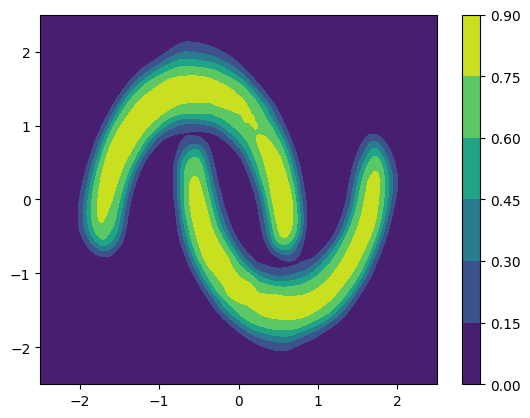

In [12]:
plot_discriminator(disc)

**(c) Why does the discriminator not predict 1.00 inside the moons?<span style="float:right"> (1 point)</span>**

Because the generator also produces fakes that are inside the "bananas" and therefore, the discriminator cannot be sure whether it is s real or fake example.

## 9.7 Experiment: Train the generator and discriminator (8 points)

We'll now train the model with the trainable generator.

**(a) Train the generator and discriminator together:**

In [11]:
device= d2l.try_gpu()

gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen, disc, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

Epoch 0: disc_loss=0.909228 gen_loss=1.639291  disc_acc=0.768257 gen_acc=0.193434
Epoch 1: disc_loss=1.252316 gen_loss=0.930932  disc_acc=0.629601 gen_acc=0.307914
Epoch 2: disc_loss=1.328666 gen_loss=0.814734  disc_acc=0.589284 gen_acc=0.336037
Epoch 3: disc_loss=1.363194 gen_loss=0.741077  disc_acc=0.545302 gen_acc=0.402504
Epoch 4: disc_loss=1.322460 gen_loss=0.841288  disc_acc=0.583700 gen_acc=0.350983
Epoch 5: disc_loss=1.370357 gen_loss=0.729296  disc_acc=0.536030 gen_acc=0.399916
Epoch 6: disc_loss=1.375663 gen_loss=0.715207  disc_acc=0.519381 gen_acc=0.412154
Epoch 7: disc_loss=1.380406 gen_loss=0.702425  disc_acc=0.511764 gen_acc=0.477891
Epoch 8: disc_loss=1.346717 gen_loss=0.813489  disc_acc=0.555357 gen_acc=0.387428
Epoch 9: disc_loss=1.377344 gen_loss=0.720056  disc_acc=0.530266 gen_acc=0.449998
Epoch 10: disc_loss=1.383401 gen_loss=0.699016  disc_acc=0.510615 gen_acc=0.525336
Epoch 11: disc_loss=1.382441 gen_loss=0.700217  disc_acc=0.514391 gen_acc=0.553778
Epoch 12: disc

**(b) Run the code below to plot the generated samples, the discriminator output, and the real samples.**

**Note:** If you don't get a good results, try to run the model again. This model is quite sensitive to the random initialisation.

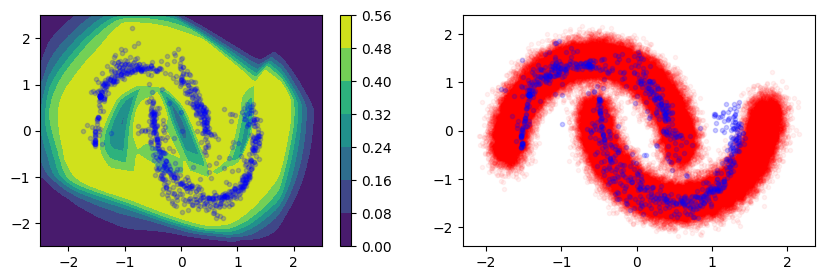

In [14]:
device='cpu'

def plot_generator(generator, n_samples=1000, device=device):
    x = torch.rand((n_samples, 100)).to(device) * 2 - 1
    y = generator(x).detach().cpu().numpy()
    plt.plot(y[:, 0], y[:, 1], 'b.', alpha=0.2)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
disc = disc.to(device)
plot_discriminator(disc, device=device)
gen = gen.to(device)
plot_generator(gen, device=device)
plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.05)
plot_generator(gen)

**(c) Briefly discuss this result.<span style="float:right"> (1 point)</span>**

Running the training multiple times, we had a very different result. The generator and discriminator seem to compete well, and it really depends on the random which is better in reach epoch. If one of the network accuracies is better, the other is worse. This is because, the discriminator has a hard time if the generator gets too good, while the generator does not get proper feedback if the discriminator is too bad.

Compare the output of the new discriminator with the output of the discriminator trained without a generator.

**(d) Are the discriminator outputs the same? Explain why this happens.<span style="float:right"> (1 point)</span>**

No, the discriminators are far from being the same. This is because the discriminator trained with a proper generator has a much harder time discriminating. Therefore, the results are worse.

**(e) Does the discriminator still reach a high accuracy? Why (not?)<span style="float:right"> (1 point)</span>**

No, the discriminator does not reach a high accuracy anymore, because it is basically impossible to distinguish, because the generator generates actually real-looking instances.

**(f) How can we see if the model is working well based on the discriminator accuracy?<span style="float:right"> (2 points)</span>**

If the discriminator has a bad accuracy, this can have two reasons. Either the discriminator is not very good, or the generator is excellent. This means that a low discriminator accuracy is an indication of a good generator model, but not a guarantee.

**(g) Compare the distribution learned by the generator with the real distribution. What are the main differences?<span style="float:right"> (1 point)</span>**

The generated samples highly depend on the individual run, and mostly match the real data. What seems different across multiple runs is that the "bananas are thinner," i.e., the generated samples spread less than the real data.

**(h) Explain the differences you observed above: Why are the generated and real distributions different?<span style="float:right"> (1 point)</span>**

This is because the generators' only goal is to convince the discriminator, which generally has a higher chance of success if the generated data are in the middle of the original ones, compared to be on the edge.

**(i) How can you make the distributions more similar?<span style="float:right"> (1 point)</span>**

One way of fixing the issue is to rebalance how strong the generator is in comparison to the discriminator, for example, by changing the networks' complexity or the size of the mini baches per iteration. Another option is to also optimize for a biggest-possible distance between the individual generated points.

## 9.8 Gradient reversal (5 point)

As an alternative to training the discriminator and generator separately, we can also train the model with a gradient reversal layer that reverses the gradient coming from the discriminator:

```
Forward: generator -> discriminator.
Backward: generator gradient <- gradient reversal <- discriminator gradient.
```

In PyTorch, we'll implement this as a function `revgrad(x)` that will reverse the gradient that passes through it. You can use it like this:
```
y = discriminator(revgrad(generator(x)))
loss = loss_fn(y, target)
loss.backward()
```

**(a) Complete the code to define the `revgrad` gradient reversal function:<span style="float:right"> (1 point)</span>**

In [11]:
class RevGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = input
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # TODO: Compute the reverse of the gradient
        grad_input = (-grad_output)
        return grad_input

revgrad = RevGrad.apply

The training loop is now a bit simpler than before, because we do not have to compute the generator loss separately.

**(b) Complete the new training function:<span style="float:right"> (1 point)</span>**

In [12]:
def train_adversarial_revgrad(generator, discriminator, data_loader, epochs=10, lr=0.001, device=device):
    parameters = list(generator.parameters()) + list(discriminator.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc_real = 0
        epoch_acc_fake = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            # generate fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # run discriminator on real and random samples,
            # reverse the gradient for the generator
            d_real = discriminator(x_real)
            # TODO: compute the discriminator output like before,
            #       but include the gradient reversal layer
            d_fake = discriminator(revgrad(x_fake))

            # compute loss
            loss_real = bce_logits_loss(d_real, torch.ones_like(d_real))
            loss_fake = bce_logits_loss(d_fake, torch.zeros_like(d_fake))
            loss = loss_real + loss_fake
            
            # compute discriminator accuracy
            acc_real = torch.mean((d_real > 0).to(torch.float))
            acc_fake = torch.mean((d_fake < 0).to(torch.float))

            # update generator and discriminator
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_loss += loss.item()
            epoch_acc_real += acc_real.item()
            epoch_acc_fake += acc_fake.item()
            mb_count += 1

        print('Epoch %d: loss=%f  acc_real=%f acc_fake=%f' %
              (epoch, epoch_loss / mb_count,
               epoch_acc_real / mb_count, epoch_acc_fake / mb_count))

**(c) Train a generator and discriminator with the new training function:**

In [27]:
device=d2l.try_gpu()

gen = MoonGenerator().to(device)
disc = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial_revgrad(gen, disc, loader, epochs=10, lr=0.001, device=device)

Epoch 0: loss=0.971843  acc_real=0.776205 acc_fake=0.740859
Epoch 1: loss=1.194012  acc_real=0.692915 acc_fake=0.636869
Epoch 2: loss=1.271996  acc_real=0.630475 acc_fake=0.617377
Epoch 3: loss=1.344113  acc_real=0.562170 acc_fake=0.567565
Epoch 4: loss=1.368385  acc_real=0.526594 acc_fake=0.537764
Epoch 5: loss=1.283385  acc_real=0.583360 acc_fake=0.600843
Epoch 6: loss=1.382773  acc_real=0.504715 acc_fake=0.517833
Epoch 7: loss=1.337257  acc_real=0.547674 acc_fake=0.553229
Epoch 8: loss=1.384425  acc_real=0.477312 acc_fake=0.538873
Epoch 9: loss=1.384365  acc_real=0.585048 acc_fake=0.424243


**(d) Plot and inspect the results:**

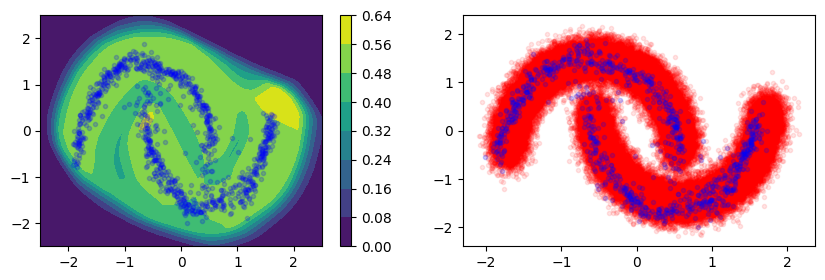

In [28]:
device='cpu'

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
disc = disc.to(device)
plot_discriminator(disc, device=device)
gen = gen.to(device)
plot_generator(gen, device=device)

plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen, device=device)

**(e) Briefly discuss the result.<span style="float:right"> (1 point)</span>**

The results look very similar to what we got with the previous approach of calculating the loss.

**(f) What are some advantages and disadvantages of the gradient reversal layer, compared with the previous two-step approach?<span style="float:right"> (2 points)</span>**

One advantage of the reversal layer is that we need less computational power, as we have to compute fewer gradients. One disadvantage can be that the discriminator and generator are tangled together more tightly, which can result in bad feedback loops.

## 9.9 Emoji dataset

For the second part of this assignment we will borrow an emoji dataset (and some ideas) from a course at the [University of Toronto](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/).

The dataset contains images of Apple-style and Windows-style emojis. You can [download the files](http://www.cs.toronto.edu/~jba/emojis.tar.gz) yourself or use the code below.

**(a) Download the dataset and extract the files:**

In [15]:
# !wget -c http://www.cs.toronto.edu/~jba/emojis.tar.gz
# !tar xzf emojis.tar.gz

We'll resize the images to 32 by 32 pixels and normalize the RGB intensities to values between -1 and 1.

**(b) Run the code to construct the datasets:**

In [24]:
import os

def image_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGBA').convert('RGB')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

emoji_path = os.path.join(os.getcwd(), "emojis")

d_windows = torchvision.datasets.ImageFolder(os.path.join(emoji_path, "Windows"), transform, loader=image_loader)
d_apple = torchvision.datasets.ImageFolder(os.path.join(emoji_path, "Apple"), transform, loader=image_loader)

**(c) Plot a few images to see the different styles:**

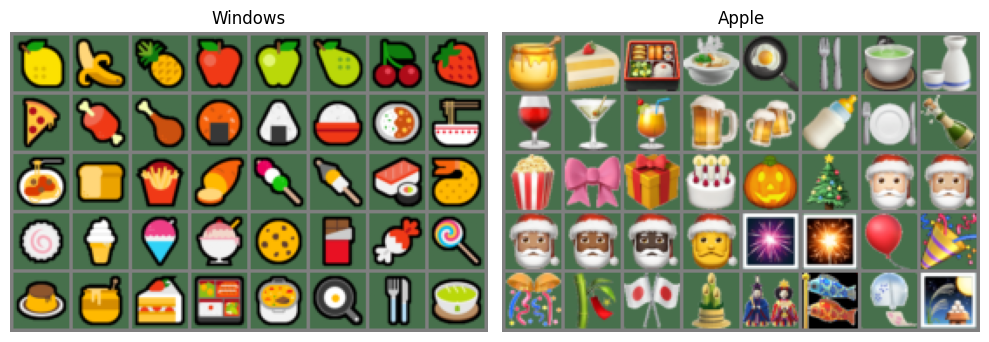

In [25]:
def image_grid(d, idxs):
    images = [d[idx][0] for idx in idxs]
    grid = torchvision.utils.make_grid(images)
    return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

# Depending on the PyTorch version, this code might print
# a warning about transparency. This is not a problem.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_grid(d_windows, range(100, 140)))
plt.title('Windows')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_grid(d_apple, range(400, 440)))
plt.title('Apple')
plt.axis('off')
plt.tight_layout()

## 9.10 CycleGAN (2 points)

We'll try to train a CycleGAN that can translate emojis between the Windows and Apple styles.

This CycleGAN has the following components:
* A generator that translates from Windows to Apple;
* A generator that translates from Apple to Windows;
* A discriminator that discriminates between real and fake emojis from the Windows distribution;
* A discriminator that discriminates between real and fake emojis from the Apple distribution.

### Generator

First, we define the generator. We'll use the same generator architecture for both directions. Unlike before, the generator does not take random noise as input, but expects a 32 by 32 RGB image as input and returns a 32 by 32 RGB image as output.

The generator has the following structure:
```
- Input: 32x32 pixels, 3 channels.
- Two downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 32 -> 64 channels.
- One convolution block in the middle:
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 64 channels.
- Two upsampling + convolution blocks:
  upsampling (scale factor 2) followed by convolution,
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 32 -> 3 channels.
- Output: 32x32 pixels, 3 channels.
```

Add batch normalization and ReLU activations after each convolution, except after the very last layer.

The images have a [-1, +1] range, so the last output should use a tanh activation without BN.

**(a) Complete the code below:<span style="float:right"> (2 points)</span>**

In [33]:
class CycleGenerator(torch.nn.Module):
    def __init__(self, input_size=100):
        super().__init__()
        self.input_size = input_size
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 pixels
            # TODO: implement the downsampling part as described above
            torch.nn.Conv2d(3, 32, (5, 5), stride=2, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),

            torch.nn.Conv2d(32, 64, (5, 5), stride=2, padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),

            # no downsampling, no upsampling
            torch.nn.Conv2d(64, 64, (5, 5), padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            # upsampling 8 -> 16 -> 32 pixels
            # TODO: complete the upsampling part as described above
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(64, 32, (5, 5), stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(32, 3, (5, 5), stride=1, padding=2),
            torch.nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

# the output should have the same shape as the input
assert CycleGenerator()(torch.zeros((30, 3, 32, 32))).shape == torch.Size([30, 3, 32, 32]), "the output should have the same shape as the input"
assert torch.min(CycleGenerator()(torch.zeros((30, 3, 32, 32)))) > -1, "outputs should be in the range [-1,1]"
assert torch.max(CycleGenerator()(torch.zeros((30, 3, 32, 32)))) < 1,  "outputs should be in the range [-1,1]"

### Discriminator

The discriminator is similar in concept to what we had in the GAN model: it takes an image and predicts 1 for a real image and 0 for a fake.

```
- Input: 32x32 pixels, 3 channels.
- Three downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 64 -> 64 -> 64 channels.
- One fully connected layer from (64*4*4) to 1.
- Output: 1 output element.
```

Add batch normalization and ReLU after each convolution, except at the end of the network.

**(b) Read through the code below:**

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 -> 4
            torch.nn.Conv2d(3, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(64 * 4 * 4, 1)
        )
        # Note: Although this is a binary classifier, we do not apply
        #       a sigmoid activation here. We'll optimize a mean-squared
        #       error to make the discriminator's task a bit harder and
        #       get a slightly better gradient.

    def forward(self, x):
        return self.net(x)

# the output shape should be (30, 1)
assert Discriminator()(torch.zeros((30, 3, 32, 32))).shape == torch.Size([30, 1]), "the output should have shape [30,1]"

## 9.11 CycleGAN training loop (2 points)

The training loop for the GAN with cycle-consistency loss follows the following procedure:

For each batch of samples from domain A and B:
* Use the generators to predict the fake B given A, and fake A given B.
* Use the generators to reconstruct A given fake B, and B given fake A.

The discriminator loss is composed of:
* The discriminator losses for real samples from A and B.
* The discriminator losses for fake samples from A and B.

The cycle-consistency loss is composed of:
* The reconstruction loss comparing the real A with the cycled A->B->A.
* The reconstruction loss comparing the real B with the cycled B->A->B.

Finally, the two groups losses are combined with a weight `lambda_cycle` for the cycle-consistency loss:

```loss = discriminator_loss + lambda_cycle * cycle-consistency loss```

**(a) Complete the code below to implement this procedure:<span style="float:right"> (2 points)</span>**

In [ ]:
def train_cycle(generator_ab, generator_ba, discriminator_a, discriminator_b,
                data_loader_a, data_loader_b,
                epochs=10, lr=0.001, lambda_cycle=0.1, device=device):
    mse_loss = torch.nn.MSELoss()
    models = torch.nn.ModuleList([generator_ab, generator_ba, discriminator_a, discriminator_b])
    optimizer = torch.optim.Adam(models.parameters(), lr=lr, betas=(0.5, 0.999))
    
    plt.figure(figsize=(10, 15))

    for epoch in range(epochs):
        epoch_stats = defaultdict(lambda: 0)
        mb_count = 0

        disc_a.train()
        disc_b.train()
        gen_ab.train()
        gen_ba.train()

        for (real_a, _), (real_b, _) in zip(loader_a, loader_b):
            real_a = real_a.to(device)
            real_b = real_b.to(device)

            # compute fake images A->B->A
            fake_ab = generator_ab(real_a)
            cycle_aba = generator_ba(fake_ab)

            # compute fake images B->A->B
            fake_ba = generator_ba(real_b)
            cycle_bab = generator_ab(fake_ba)

            # run discriminator on real and fake images
            d_real_a = discriminator_a(real_a)
            # TODO: compute other discriminator output, use gradient reversal where necessary
            d_real_b = ...   # TODO
            d_fake_ba = ...  # TODO
            d_fake_ab = ...  # TODO

            # compute discriminator loss
            # we optimize the MSE loss function to make the gradients of
            # the discriminator a bit easier to use
            loss_real_a = mse_loss(d_real_a, torch.ones_like(d_real_a))
            loss_real_b = ...  # TODO
            loss_fake_a = ...  # TODO
            loss_fake_b = ...  # TODO

            # compute cycle-consistency loss
            loss_cycle_a = mse_loss(cycle_aba, real_a)
            loss_cycle_b = mse_loss(cycle_bab, real_b)

            # compute loss
            loss = loss_real_a + loss_real_b + \
                   loss_fake_a + loss_fake_b + \
                   lambda_cycle * (loss_cycle_a + loss_cycle_b)

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_stats['loss'] += loss.item()
            epoch_stats['loss_real_a'] += loss_real_a.item()
            epoch_stats['loss_real_b'] += loss_real_b.item()
            epoch_stats['loss_fake_a'] += loss_fake_a.item()
            epoch_stats['loss_fake_b'] += loss_fake_b.item()
            epoch_stats['loss_cycle_a'] += loss_cycle_a.item()
            epoch_stats['loss_cycle_b'] += loss_cycle_b.item()
            mb_count += 1

        if epoch % 5 == 0:
            print('Epoch %d: ' % epoch, end='')
            for k, v in epoch_stats.items():
                print(' %s=%6.4f' % (k, v / mb_count), end='')

            images_for_plot = {
                'real_a': real_a, 'fake_ab': fake_ab, 'cycle_aba': cycle_aba,
                'real_b': real_b, 'fake_ba': fake_ba, 'cycle_bab': cycle_bab,
            }

            for k in range(10):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(10, 6, k * 6 + i + 1)
                    plt.imshow(im[k].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if k == 0:
                        plt.title(im_title)
                    plt.axis('off')
            plt.tight_layout()
            display.display(plt.gcf())
            display.clear_output(wait=True)

## 9.12 Experiment: CycleGAN training (6 points)

We can now train our CycleGAN model.

**(a) Run the code below and play with the hyperparameters if necessary to learn a reasonable output.**

Note that GANs can be notoriously difficult to train, so don't worry if your results are not perfect. Hopefully, you will be able to get somewhat recognizable results, but it's more important that you can interpret and discuss what happens.

In [ ]:
gen_ab = CycleGenerator().to(device)
gen_ba = CycleGenerator().to(device)
disc_a = Discriminator().to(device)
disc_b = Discriminator().to(device)

loader_a = torch.utils.data.DataLoader(d_windows, batch_size=32, shuffle=True, num_workers=4)
loader_b = torch.utils.data.DataLoader(d_apple, batch_size=32, shuffle=True, num_workers=4)

train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=1, device=device)

**(b) Discuss your results and training experience. Was the model easy to train? What do you think of the results? Does it learn a good translation between Windows and Apple emojis?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(c) Run some more experiments to study the effect of the `lambda_cycle` weight.<span style="float:right"> (1 point)</span>**

In [ ]:
# TODO: Your experiments here.

**(d) What is the effect of the `lambda_cycle` weight? What happens if you set it to a much larger value? What happens if you set it to 0? Can you explain this?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(e) Why is the reconstructed output (A->B->A or B->A->B) usually better than the translated output (A->B or B->A)?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## 9.13 Final questions (4 points)

**(a) Discuss how the balance between the generator and discriminator affects GAN training. What can go wrong if one part is better or learns more quickly than the other?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(b) CycleGAN and similar methods are unsupervised models that learn to map inputs from one domain to another. Does this mapping necessarily preserve the semantics of the images? Why, or why not?<span style="float:right"> (1 point)</span>**
<br>(For example, think about how our emoji model would translate flags.)

TODO: Your answer here.

**(c) Have a brief look at [CycleGAN, a Master of Steganography](https://arxiv.org/pdf/1712.02950.pdf), a paper published at NIPS 2017. The authors show that a CycleGAN network sometimes 'hides' information in the generated images, to help with the reconstruction. Can you see something like this in your results as well?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 30 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version d7aee7b / 2023-11-09</span>